
Made by Roman Kiryanov, roman.kiryanov@skoltech.ru


## Initialization

### Preinstall required libraries

In [0]:
#!pip install dlib
#!pip install opencv-python
#!pip install --upgrade imutils

import dlib
import cv2

import numpy as np
import pandas as pd

import imutils
import os

from PIL import Image

from matplotlib import pyplot as plt

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

In [0]:
from sklearn.model_selection import cross_val_score

### Drive mounting for Data

In [4]:
# mounting drive folder

from google.colab import drive
drive.mount('/content/gdrive') #, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = 'gdrive/My Drive/Colab Notebooks/DL_Project/'
cwd = os.getcwd()
os.chdir(path)

In [0]:
def plot_vectors(vectors_array, names_array, print_areas=True):
  
    plt.figure(figsize=(16,8))
    plt.title('Median of vectors', fontsize=16)
    plt.xlabel('Points', fontsize=12)
    plt.ylabel('$\Delta$, pix', fontsize=12)
    
    std_max = 0
    for vectors, name in zip(vectors_array, names_array):
        median = np.median(vectors, axis=0)
        std = np.std(vectors, axis=0)
        if (median+std).max() > std_max:
            std_max = (median+std).max()
        
        x = np.linspace(0,len(median),len(median))
        plt.plot(median, label=name)
        plt.fill_between( x, median+std, median-std, alpha=0.2)
    
    if print_areas:
        plt.plot(np.ones(10)*17,np.linspace(-5,std_max+2,10),'black',alpha=0.5)
        plt.plot(np.ones(10)*28,np.linspace(-5,std_max+2,10),'black',alpha=0.5)
        plt.plot(np.ones(10)*48,np.linspace(-5,std_max+2,10),'black',alpha=0.5)
        plt.plot(np.ones(10)*37,np.linspace(-5,std_max+2,10),'black',alpha=0.5)
    
        plt.text(5,std_max+1,'Jaw', fontsize=16)
        plt.text(19,std_max+1,'EyeBrows', fontsize=16)
        plt.text(31,std_max+1,'Nose', fontsize=16)
        plt.text(40,std_max+1,'Eyes', fontsize=16)
        plt.text(52,std_max+1,'Mouth', fontsize=16)
        
    plt.ylim([-5,std_max+3])
    plt.xlim([0, len(median)])
    plt.legend()
    plt.show()

In [0]:
def cut_slice(vectors, part):
    if part == 'Jaw':
        return np.array(vectors)[:,:17]
    elif part == 'EyeBrows':
        return np.array(vectors)[:,17:27]
    elif part == 'Nose':
        return np.array(vectors)[:,27:36]
    elif part == 'Eyes':
        return np.array(vectors)[:,36:48]
    elif part == 'Mouth':
        return np.array(vectors)[:,48:]
    elif type(part) == list:
        return np.array(vectors)[:,part[0]:part[1]]
    else:
        print('Not recognoised ')
        return None

# Previous

## Get table data

In [0]:
datadir = 'Twins'

metadata = pd.read_csv(f'{datadir}/twins-relationship-info.csv', index_col = 0)
metadata['subject_id1'] = metadata['subject_id1'].apply(lambda x: int(x.split('S')[1]))
metadata['subject_id2'] = metadata['subject_id2'].apply(lambda x: int(x.split('S')[1]))

# filter 
metadata_identical = metadata[(metadata['relationship_type']=='Identical')]
metadata_fraternal = metadata[(metadata['relationship_type']=='Fraternal')]
metadata_sibling   = metadata[(metadata['relationship_type']=='Sibling')]

#metadata_different = metadata[(metadata['relationship_type']=='Fraternal') | (metadata['relationship_type']=='Sibling')]

print(len(metadata_identical), len(metadata_fraternal), len(metadata_sibling))
#metadata_different.head()


352 32 8


### Convert table data to dict
Я использую Counter так как обычный дикт при запросе несуществующего элемента выкинет ошибку, а этот - 0

In [0]:
from collections import Counter

In [0]:
identical = Counter()
for i, subj_id1 in enumerate( metadata_identical[['subject_id1', 'subject_id2']].values):  
    identical[subj_id1[0]] = subj_id1[1]
    
fraternal = Counter()
for i, subj_id1 in enumerate( metadata_fraternal[['subject_id1', 'subject_id2']].values):  
    fraternal[subj_id1[0]] = subj_id1[1]

sibling = Counter()
for i, subj_id1 in enumerate( metadata_sibling[['subject_id1', 'subject_id2']].values):  
    sibling[subj_id1[0]] = subj_id1[1]

In [0]:
len(identical), len(fraternal), len(sibling)

(352, 32, 6)

Form different class as all in equal persentage

In [0]:
different = Counter()
different = sibling.copy()

frat_values = list(fraternal.values())
np.random.shuffle(frat_values)
for i in range(0,20):
    different[frat_values[i]] = fraternal[frat_values[i]]

iden_values = list(identical.values())
np.random.shuffle(iden_values)
for i in range(0,20):
    different[iden_values[i]] = identical[iden_values[i]]

In [0]:
len(different)

46

### One more table with views
Сортировка информации о том какие файлы какие имеют виды. Берем только фронтальные

In [0]:
datadir = 'Twins'

metadata2 = pd.read_csv(f'{datadir}/image-metadata-2.0.csv')
# filter 
metadata2 = metadata2[(metadata2[' yaw']==0)&(metadata2[' expression']!=' Happiness')&(metadata2[' glasses']==' none')]
metadata2['person_id'] = metadata2['filename'].apply(lambda x: int(x.split('d')[0]))
metadata2['view_id'] = metadata2['filename'].apply(lambda x: x.split('d')[1].split('.')[0])

df_ids_views = metadata2.groupby('person_id').view_id.apply(tuple).to_frame()

In [0]:
df_ids_views.head()

,view_id
person_id,
90003,"(17, 18, 40, 42, 60, 61)"
90004,"(17, 18, 40, 42, 60, 61, 83, 95, 98, 110, 114,..."
90005,"(17, 18, 40, 42, 60, 61, 83, 95, 98, 110, 114,..."
90006,"(14, 15, 37, 39, 57, 58)"
90007,"(17, 18, 36, 54, 55)"


In [0]:
views = Counter()
for i, num in enumerate( list(df_ids_views.index) ):
    views[num] = list(df_ids_views.values)[i]

### Data Loader
Простенький даталоадер который берет изображение, определяет по таблице близнеца и загружает все возможные пары видов

In [0]:
def get_img_path(img_id, view):
    #return os.path.join('twins_aligned_cropped_resized', f'{img_id}/{img_id}d{view}__face.jpg')
    return os.path.join('Twins','nd-twins-0006/faces', f'{img_id}/{img_id}d{view}__face.jpg')

In [0]:
def load_same_person_pairs(pairs, views):
    pairs_keys = np.array(list(pairs.keys()))
  
    for id_X in pairs_keys:
        np.random.shuffle(pairs_keys)
        id_a = pairs_keys[0]
        try:
            views_a = views[id_a][0]
        except TypeError:
            views_a = views[id_a]
        for i in range(0, len(views_a)-1):
            for j in range(i+1, len(views_a)):
                path_a = get_img_path(id_a, views_a[i])
                path_b = get_img_path(id_a, views_a[j])
                im_A = Image.open(path_a)
                im_B = Image.open(path_b)
                yield [im_A, im_B]

In [0]:
def load_different_person_pairs(pairs, views):
    pairs_keys = np.array(list(pairs.keys()))
    
    for id_X in pairs_keys:
        np.random.shuffle(pairs_keys)
        id_a = pairs_keys[0]
        id_b = pairs[id_a]
        
        try:
            views_a = views[id_a][0]
        except TypeError:
            views_a = views[id_a]
        try:
            views_b = views[id_b][0]
        except TypeError:
            views_b = views[id_b]
        for i in views_a:
            for j in views_b:
                path_a = get_img_path(id_a, i)
                path_b = get_img_path(id_b, j)
                im_A = Image.open(path_a)
                im_B = Image.open(path_b)
                yield [im_A, im_B]

In [0]:
a = next(iter(load_different_person_pairs(fraternal, views)))
b = next(iter(load_same_person_pairs(fraternal, views)))
c = next(iter(load_different_person_pairs(sibling, views)))
d = next(iter(load_different_person_pairs(identical, views)))

FileNotFoundError: ignored

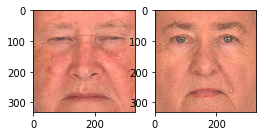

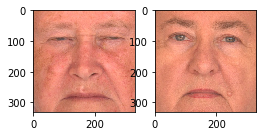

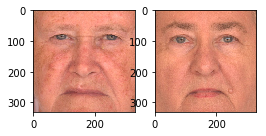

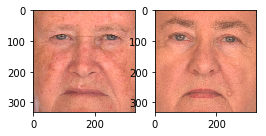

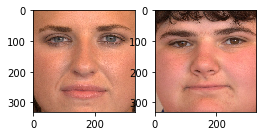

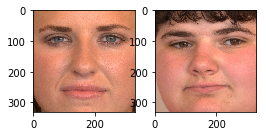

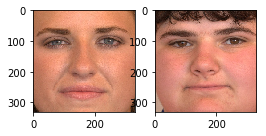

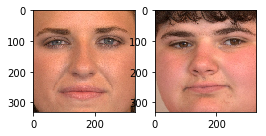

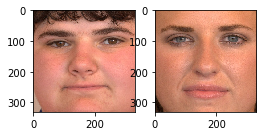

In [0]:
coun = 1
for [A, B] in iter(load_different_person_pairs(fraternal, views)):
    plt.figure(figsize=(4,3))
    plt.subplot(121)
    plt.imshow(A)
    plt.subplot(122)
    plt.imshow(B)
    plt.show()
    coun +=1
    if coun == 10:
        break
    

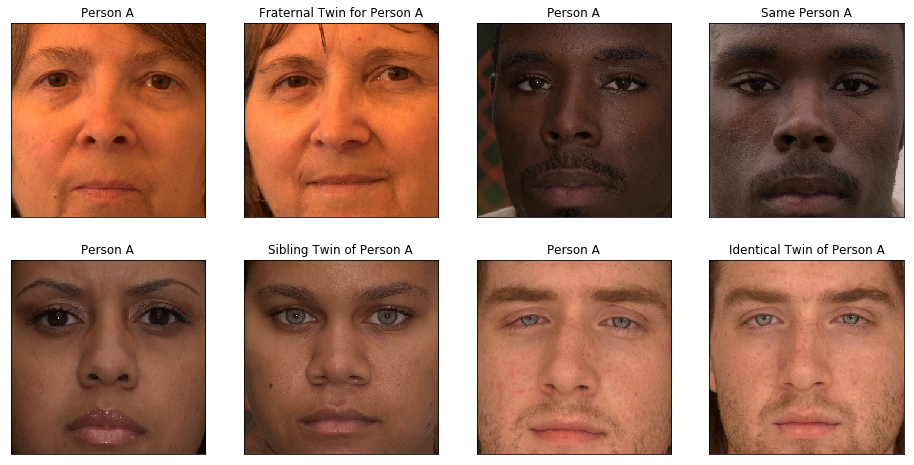

In [0]:
plt.figure(figsize=(16,8))
plt.subplot(241, title='Person A', xticks=(()), yticks=(()))
plt.imshow(a[0])
plt.subplot(242, title='Fraternal Twin for Person A', xticks=(()), yticks=(()))
plt.imshow(a[1])

plt.subplot(243, title='Person A', xticks=(()), yticks=(()))
plt.imshow(b[0])
plt.subplot(244, title='Same Person A', xticks=(()), yticks=(()))
plt.imshow(b[1])

plt.subplot(245, title='Person A', xticks=(()), yticks=(()))
plt.imshow(c[0])
plt.subplot(246, title='Sibling Twin of Person A', xticks=(()), yticks=(()))
plt.imshow(c[1])

plt.subplot(247, title='Person A', xticks=(()), yticks=(()))
plt.imshow(d[0])
plt.subplot(248, title='Identical Twin of Person A', xticks=(()), yticks=(()))
plt.imshow(d[1])
plt.show()

## Preprocess Functions

In [0]:
os.chdir(cwd)
from dlib_fd import dlib_landmark_detector # face detector

In [0]:
os.chdir(path)

In [0]:
# initialize detector:
# cnn_flag = True to use CNN-based model.If False, use HOG-based model
# bb_detector_path = full path except name to bounding box detector (first stage of face detection)
# landmark_predictor_path = full path except name to 68-points trained weights for detector of face landmarks

dfd = dlib_landmark_detector(cnn_flag='True', 
                             bb_detector_path = './mmod_human_face_detector.dat', 
                             landmark_predictor_path = './shape_predictor_68_face_landmarks.dat' )

In [0]:
def distance(shape1, shape2): 
    return np.sqrt( np.power(shape1 - shape2, 2).sum(axis=1)) #MSE

In [0]:
def get_features( pairs, views, cut_off_num, same_preson=False, flipped=False):
    vectors = []
    counter, nd = 1, 0
    
    if same_preson:
        load = load_same_person_pairs
    else:
        load = load_different_person_pairs
    
    for [img_A, img_B] in iter(load(pairs, views)): 
        # Face A prepare
        img_8bit = np.array( img_A )
        img_8bit = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
        # Face A detect
        dfd.reset()
        dfd.face_detect(img_8bit, visualize=False)
        
        # Face A crop and center
        face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
        dfd.reset()
        dfd.face_detect(face_cropped, visualize=False)
        # Face A get landmark points
        A__img_shape = dfd.get_original_size_landmarks()
        
        if flipped:
            if same_preson:
                # A - A_flipped
                face_cropped = np.flip(face_cropped, axis=1)
                dfd.reset()
                dfd.face_detect(face_cropped, visualize=False)
                B__img_shape = dfd.get_original_size_landmarks()
            else:
                # A - B_Flipped
                img_8bit = np.array( img_B )
                img_8bit = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
                dfd.reset()
                dfd.face_detect(img_8bit, visualize=False)
                face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
                
                face_cropped = np.flip(face_cropped, axis=1)
                dfd.reset()
                dfd.face_detect(face_cropped, visualize=False)
                B__img_shape = dfd.get_original_size_landmarks()
        else:
            # A - B
            img_8bit = np.array( img_B )
            img_8bit = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
            dfd.reset()
            dfd.face_detect(img_8bit, visualize=False)
            face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
            dfd.reset()
            dfd.face_detect(face_cropped, visualize=False)
            B__img_shape = dfd.get_original_size_landmarks()
        
        
        if (A__img_shape is None) or (B__img_shape is None):
            nd +=1
        else:
            vectors.append(distance(A__img_shape, B__img_shape))
            counter+=1
        
        if counter == cut_off_num:
            break
    print('Detected:', counter, 'N/Detected:', nd)
    return vectors

## Get features

### Place for test

Тест 1. 
A - A_flipped vs A - A_twin_flip 

In [0]:
vectors_A_vs_A_flipped = get_features(different, views, 1000, same_preson=True, flipped=True)
vectors_A_vs_A_twin = get_features(different, views, len(vectors_A_vs_A_flipped), same_preson=False, flipped=False)

Detected: 543 N/Detected: 2
Detected: 542 N/Detected: 0


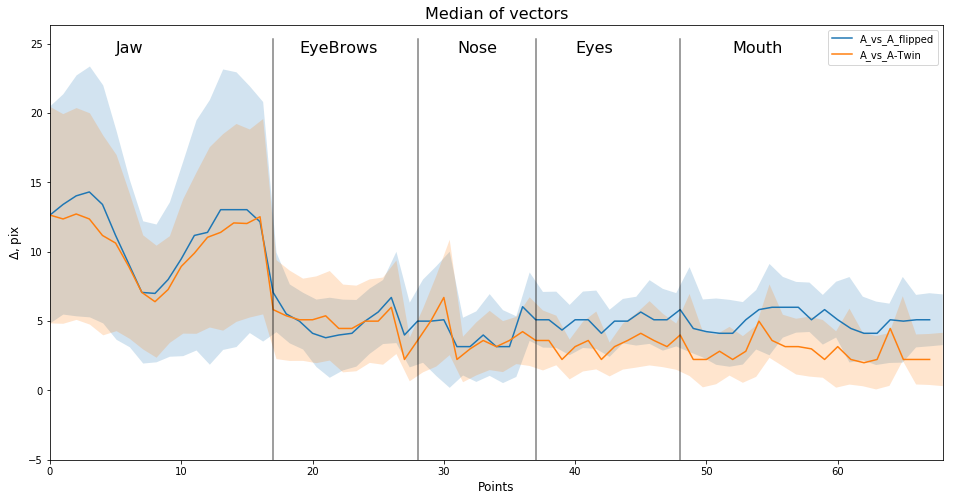

In [0]:
plot_vectors([vectors_A_vs_A_flipped, vectors_A_vs_A_twin], ['A_vs_A_flipped', 'A_vs_A-Twin'])

In [0]:
#eyebrows
part_1_class_1, part_1_class_0 = cut_slice(vectors_A_vs_A_flipped, [18,36]), cut_slice(vectors_A_vs_A_twin_flipped,[18,36])
#mouth
part_2_class_1, part_2_class_0 = cut_slice(vectors_A_vs_A_flipped, 'Mouth'), cut_slice(vectors_A_vs_A_twin_flipped,'Mouth') 

In [0]:
X = np.concatenate([part_1_class_1, part_1_class_0], axis = 0)
y = np.concatenate([np.ones(len(part_1_class_1)).astype(int), np.zeros(len(part_1_class_0)).astype(int)], axis =0)

In [0]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)

In [0]:
len(X_train), len(X_test)

(507, 338)

In [0]:
svm = SVC(kernel='linear')

In [0]:
acc = []
for _ in range(5):
    X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)
    svm = SVC(kernel='rbf')
    svm.fit(X=X_train, y=y_train)
    y_pred = svm.predict(X=X_test)
    acc.append(accuracy_score(y_test, y_pred).round(5))
    print(accuracy_score(y_test, y_pred).round(5))
acc = np.array(acc)
print(acc.min(), acc.max(), acc.mean(), acc.std())

0.94675
0.9645
0.95266
0.95562
0.95266
0.94675 0.9645 0.954438 0.005797738869593925


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

### Others

Фотографии одно и того же человека и идентичных близнецов (identical)


In [0]:
vectors_same = get_features(identical, views, 25, same_preson=True, flipped=False)
vectors_identical = get_features(identical, views, 25, same_preson=False, flipped=False)

Detected: 25 N/Detected: 0
Detected: 25 N/Detected: 2


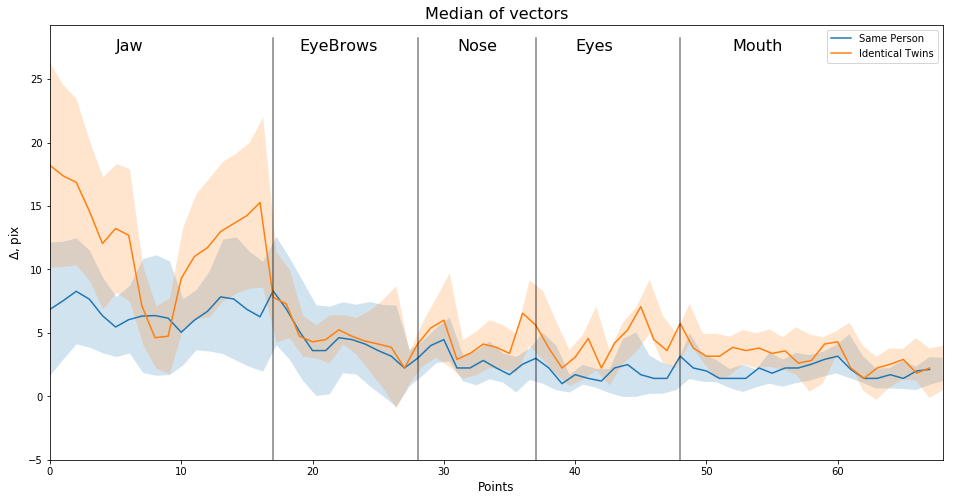

In [0]:
plot_vectors([vectors_same,vectors_identical], ['Same Person', 'Identical Twins'])

Глаза, нос и брови

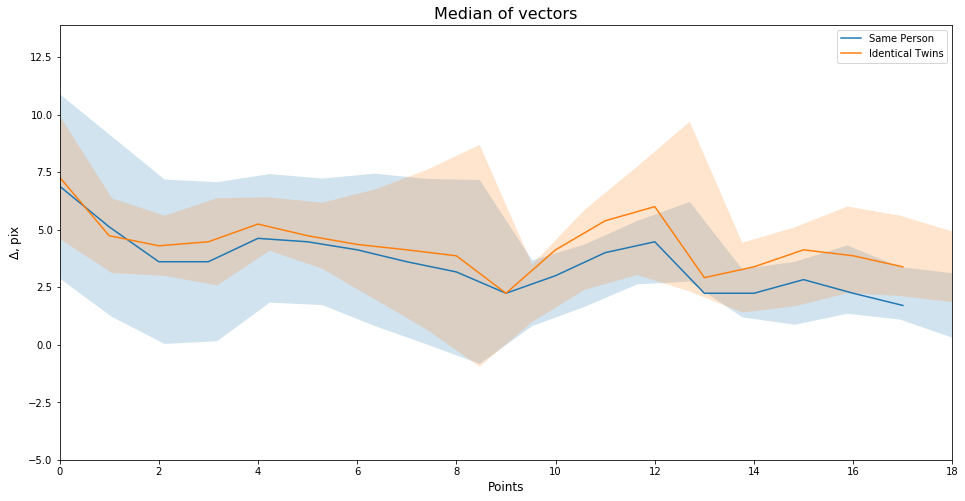

In [0]:
plot_vectors([cut_slice(vectors_same,[18,36]), cut_slice(vectors_identical,[18,36]), ], ['Same Person', 'Identical Twins',], print_areas=False)

Рот

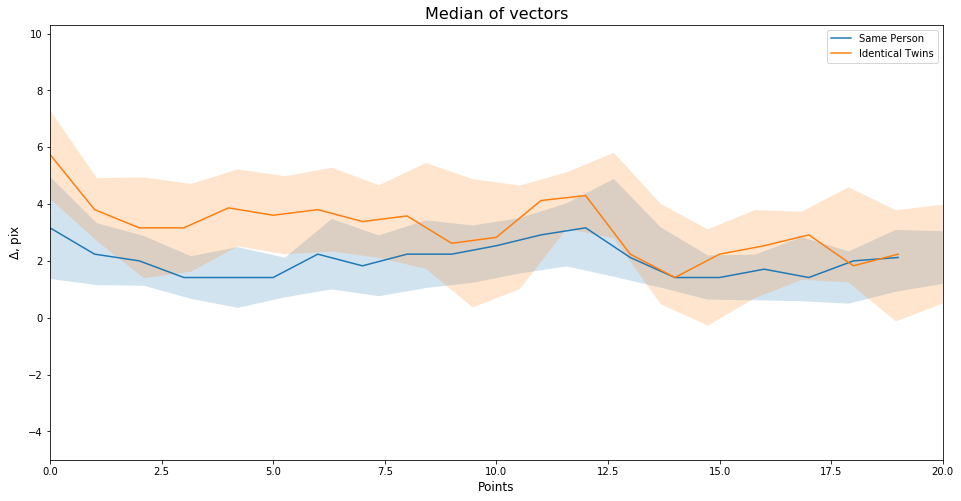

In [0]:
plot_vectors([cut_slice(vectors_same,'Mouth'), cut_slice(vectors_identical,'Mouth') ], ['Same Person', 'Identical Twins'], print_areas=False)

Same person Vs All others

In [0]:
vectors_same = get_features(different, views, 40, same_preson=True, flipped=False)
vectors_different = get_features(different, views, 40, same_preson=False, flipped=False)

Detected: 40 N/Detected: 0


TypeError: ignored

In [0]:
vectors_different = get_features(different, views, 40, same_preson=False, flipped=False)

Detected: 40 N/Detected: 2


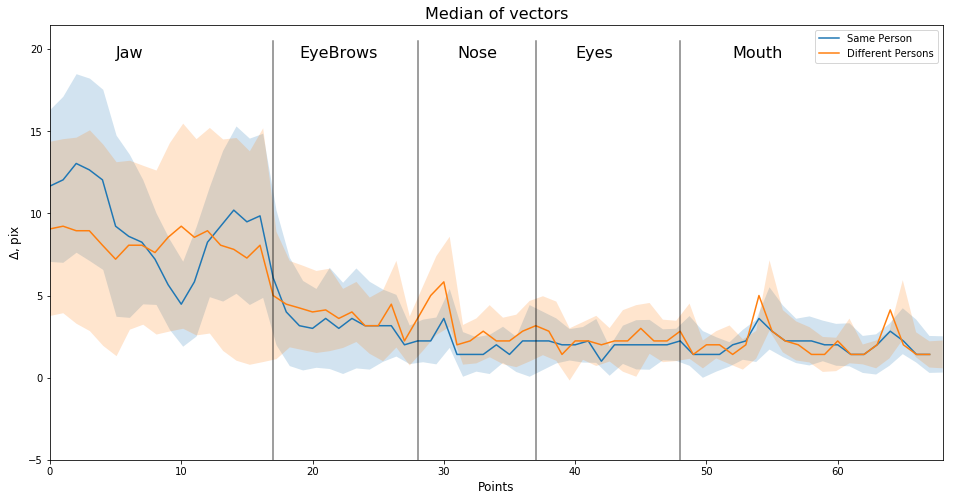

In [0]:
plot_vectors([vectors_same,vectors_different], ['Same Person', 'Different Persons'])

Mouth

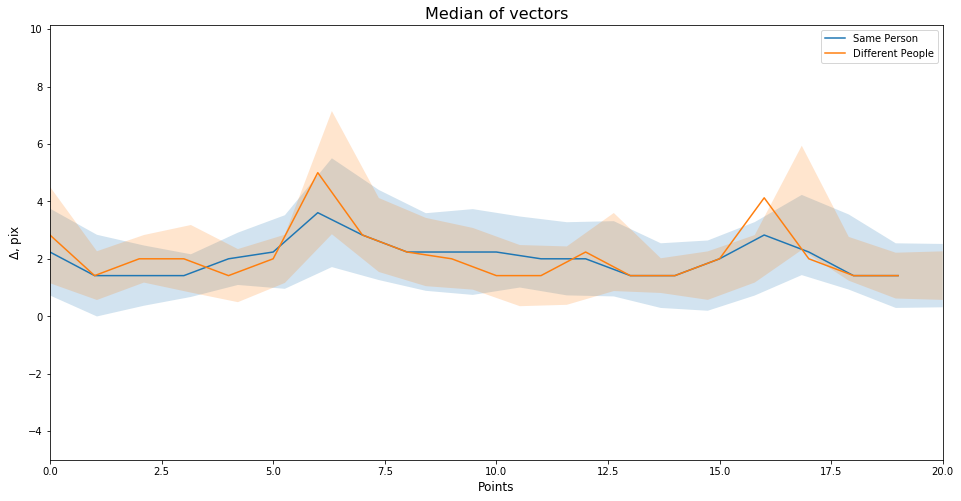

In [0]:
plot_vectors([cut_slice(vectors_same,'Mouth'), cut_slice(vectors_different,'Mouth') ], ['Same Person', 'Different People'], print_areas=False)

All other

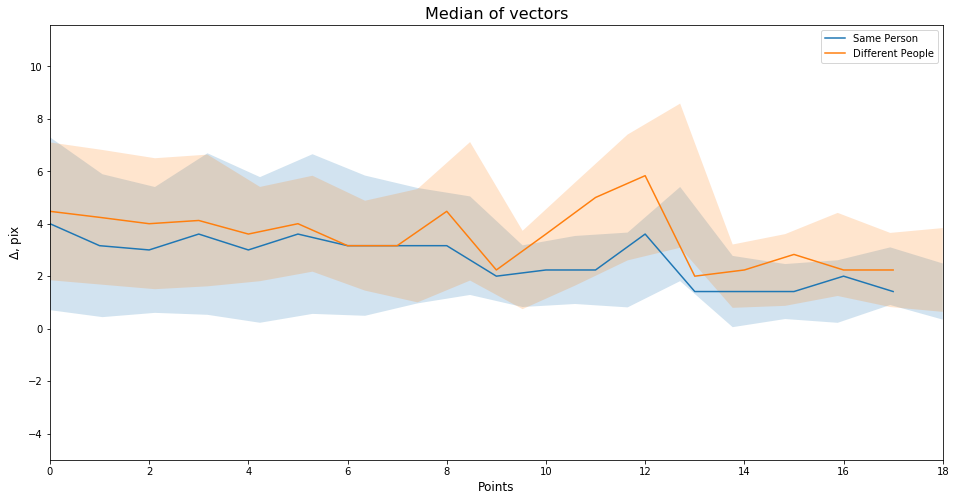

In [0]:
plot_vectors([innerface_same, innerface_different ], ['Same Person', 'Different People'], print_areas=False)

## Fit SVM Classifier

**Get only mouth features**

In [0]:
part_1_class_1, part_1_class_0 = cut_slice(vectors_A_vs_A_flipped, 'Mouth'), cut_slice(vectors_A_vs_A_twin_flipped,'Mouth') #mouth
part_2_class_1, part_2_class_0 = cut_slice(vectors_A_vs_A_flipped, [18,36]), cut_slice(vectors_A_vs_A_twin_flipped,[18,36]) #eyebrows

**Concat to X and y**

In [0]:
X = np.concatenate([part_2_class_1, part_2_class_0], axis = 0)
y = np.concatenate([np.ones(len(part_2_class_1)).astype(int), np.zeros(len(part_2_class_0)).astype(int)], axis =0)

In [0]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [0]:
svm = SVC(kernel='rbf')

In [0]:
cross_val_score(svm, X_train, y_train, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

array([0.95833333, 0.95833333, 0.95833333, 0.9787234 , 1.        ])

In [0]:
X_train.shape, X_test.shape

((237, 18), (60, 18))

In [0]:
svm.fit(X=X_train, y=y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred = svm.predict(X=X_test)

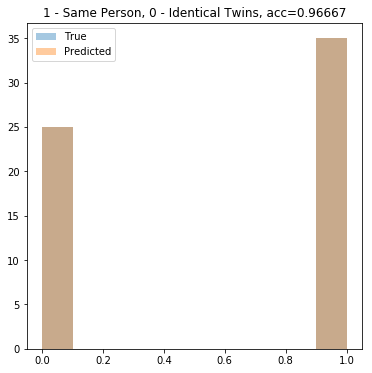

In [0]:
plt.figure(figsize=(6,6))
plt.hist(y_test, alpha=0.4, label='True')
plt.hist(y_pred, alpha=0.4, label='Predicted')
plt.title('1 - Same Person, 0 - Identical Twins, acc='+str(accuracy_score(y_test, y_pred).round(5)))
plt.legend()
plt.show()

In [0]:
def flip_kp(keypoints):
    upper, down = (keypoints[27]+keypoints[22]+keypoints[21])/3, keypoints[8]
    flipped_keypoints = []
    if (down[0] - upper[0]) !=0:
        k1 = (down[1] - upper[1])/(down[0] - upper[0])
        k2 = -1/k1
        if k2 == k1:
            k2 = k2+0.00001
    else:
        k1, k2 = 0, 0
    for point in keypoints:
        if (down[0] - upper[0]) == 0:
            distance_point = np.cross(upper - down, down - point) / np.linalg.norm(down - upper, 2)
            new_point =  [point[0]-2*distance_point, point[1]]
        elif down[1] - upper[1] == 0:
            distance_point = np.cross(upper - down, down - point) / np.linalg.norm(down - upper, 2)
            new_point =  [point[0], point[1]-2*distance_point]
        else:
            x = (upper[1] - k1*upper[0]+k2*point[0]-point[1])/(k2-k1)
            y = k2*(x-point[0])+point[1]
            new_point = [2*x - point[0], 2*y-point[1]]
            
        flipped_keypoints.append(new_point)
    flipped_keypoints.append(upper)
    return np.array(flipped_keypoints)

In [0]:
def get_vectors_new(dataframe, flip=False, stop=None):
    vectors = []
    counter = 0
    
    for id_1, id_2 in zip(dataframe['id_1'],dataframe['id_2']):
        path_1 = os.path.join('twins_aligned_cropped_resized', str(id_1))
        path_2 = os.path.join('twins_aligned_cropped_resized', str(id_2))
        
        img_1_keypoints = pd.read_csv(os.path.join(path_1,'keypoints.csv'), index_col=0)
        img_2_keypoints = pd.read_csv(os.path.join(path_2,'keypoints.csv'), index_col=0)
        
        for image_1 in img_1_keypoints.columns:
            for image_2 in img_2_keypoints.columns:
                if image_1 != image_2:
                    print(id_1, image_1,id_2, image_2)
                    
                    img_1 = cv2.cvtColor( cv2.imread(os.path.join(path_1,image_1)).astype(np.uint8), cv2.COLOR_BGR2RGB)
                    img_2 = cv2.cvtColor( cv2.imread(os.path.join(path_2,image_2)).astype(np.uint8), cv2.COLOR_BGR2RGB)
                    
                    keypoints_1, keypoints_2 = [], []
              
                    for line in img_1_keypoints[image_1]:
                        line = line.split(', ')
                        keypoints_1.append([float(line[1][:-1]), float(line[0][1:]) ])
                
                    for line in img_2_keypoints[image_2]:
                        line = line.split(', ')
                        keypoints_2.append([float(line[1][:-1]), float(line[0][1:]) ])
                    
                    keypoints_1,keypoints_2 = np.array(keypoints_1), np.array(keypoints_2)
                    
                    
                    # Plotting
                    plt.figure(figsize=(13,16))
                    plt.subplot(121)
                    #plot_ = np.zeros((600,512, 3), dtype=np.uint8)
                    plot_ = img_1                     
                    size = 3
                    for [i,j] in keypoints_1:
                        plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 0] = 255
                        plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 1] = 0
                        plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 2] = 0
                    
                    if flip:
                        keypoints_2 = flip_kp(keypoints_2)
                        
                    for [i,j] in keypoints_2:
                        plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 0] = 0
                        plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 1] = 255
                        plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 2] = 0
                    
                    plt.imshow(plot_)
                    
                    plt.subplot(122)
                    plot_ = img_2
                    for [i,j] in keypoints_1:
                        plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 0] = 255
                        plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 1] = 0
                        plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 2] = 0
                    for [i,j] in keypoints_2:
                        plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 0] = 0
                        plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 1] = 255
                        plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 2] = 0
                    
                    plt.imshow(plot_)
                    
                    #plt.colorbar()
                    plt.show()
                    
                    if flip:
                        keypoints_2 = keypoints_2[:-1]
                        
                    vectors.append( distance(keypoints_1,keypoints_2) )
                    counter += 1
                    #print(counter)
        if stop is not None:
            if counter >= stop:
                break
    return np.array(vectors)

# New dataset

In [8]:
# Get relationship
df_train = pd.read_csv('pairs_train.csv', index_col=0)
print('Train', len(df_train))
display(df_train.head())

df_test = pd.read_csv('pairs_test.csv', index_col=0)
print('Test', len(df_test))
display(df_test.head())

Train 646


,id_1,id_2,label
0,90308,90308,Same
1,90404,90404,Same
2,90062,90062,Same
3,90052,90052,Same
5,90317,90317,Same


Test 208


,id_1,id_2,label
4,90144,90144,Same
12,90412,90412,Same
15,90245,90245,Same
17,90341,90341,Same
25,90314,90314,Same


In [18]:
landmarks = pd.read_csv('aligned_landmarks.csv')
print('Train', len(landmarks))
display(landmarks.head())

landmarks_flip = pd.read_csv('aligned_FLIP_landmarks.csv')
print('Test', len(landmarks_flip))
display(landmarks_flip.head())

Train 68


,90366d13.jpg,90366d9.jpg,90046d17.jpg,90046d56.jpg,90046d57.jpg,90046d18.jpg,90326d11.jpg,90326d16.jpg,90424d13.jpg,90424d23.jpg,90290d28.jpg,90290d13.jpg,90329d25.jpg,90329d10.jpg,90043d18.jpg,90043d56.jpg,90043d57.jpg,90043d17.jpg,90288d26.jpg,90288d11.jpg,90009d110.jpg,90009d40.jpg,90009d17.jpg,90009d83.jpg,90009d42.jpg,90009d60.jpg,90009d116.jpg,90009d61.jpg,90009d95.jpg,90009d98.jpg,90009d114.jpg,90009d18.jpg,90140d23.jpg,90140d22.jpg,90140d61.jpg,90140d62.jpg,90047d56.jpg,90047d17.jpg,90047d18.jpg,90047d57.jpg,...,90268d28.jpg,90268d1.jpg,90268d16.jpg,90268d13.jpg,90217d13.jpg,90217d28.jpg,90217d32.jpg,90217d34.jpg,90217d1.jpg,90217d16.jpg,90449d13.jpg,90449d23.jpg,90400d13.jpg,90400d18.jpg,90008d98.jpg,90008d60.jpg,90008d61.jpg,90008d42.jpg,90008d110.jpg,90008d40.jpg,90008d117.jpg,90008d95.jpg,90008d17.jpg,90008d115.jpg,90008d83.jpg,90008d18.jpg,90378d11.jpg,90378d16.jpg,90386d14.jpg,90386d9.jpg,90377d16.jpg,90377d21.jpg,90281d32.jpg,90281d17.jpg,90024d57.jpg,90024d18.jpg,90024d56.jpg,90024d17.jpg,90415d28.jpg,90415d13.jpg
0,"(30, 111)","(23, 109)","(25, 87)","(34, 79)","(36, 87)","(37, 88)","(27, 95)","(21, 109)","(34, 95)","(35, 91)","(31, 86)","(28, 84)","(35, 96)","(38, 100)","(37, 92)","(34, 87)","(35, 87)","(18, 101)","(18, 70)","(23, 74)","(32, 74)","(13, 76)","(22, 82)","(14, 77)","(17, 73)","(22, 74)","(16, 76)","(27, 78)","(23, 74)","(20, 71)","(25, 68)","(24, 81)","(15, 79)","(14, 79)","(20, 83)","(10, 84)","(31, 90)","(24, 93)","(33, 92)","(31, 93)",...,"(32, 90)","(35, 90)","(35, 80)","(28, 86)","(27, 76)","(46, 77)","(36, 83)","(34, 83)","(20, 79)","(35, 78)","(26, 104)","(29, 94)","(22, 90)","(30, 90)","(37, 71)","(18, 62)","(26, 72)","(35, 73)","(40, 76)","(43, 81)","(31, 76)","(42, 75)","(33, 74)","(37, 70)","(35, 73)","(43, 81)","(44, 80)","(38, 77)","(16, 76)","(18, 67)","(29, 96)","(21, 108)","(28, 89)","(27, 91)","(41, 91)","(34, 95)","(32, 101)","(22, 97)","(26, 99)","(24, 94)"
1,"(32, 136)","(25, 135)","(26, 113)","(36, 105)","(38, 112)","(40, 112)","(29, 121)","(24, 134)","(36, 120)","(37, 115)","(34, 112)","(30, 111)","(37, 121)","(39, 125)","(39, 117)","(36, 113)","(38, 112)","(19, 129)","(20, 98)","(26, 103)","(33, 100)","(15, 104)","(25, 109)","(15, 106)","(19, 101)","(24, 102)","(19, 103)","(30, 104)","(26, 101)","(23, 100)","(28, 96)","(26, 108)","(18, 108)","(15, 106)","(22, 110)","(13, 112)","(33, 115)","(25, 118)","(35, 116)","(33, 118)",...,"(33, 114)","(36, 114)","(37, 104)","(30, 110)","(28, 101)","(47, 99)","(37, 107)","(35, 108)","(22, 109)","(36, 104)","(27, 128)","(30, 119)","(24, 116)","(33, 116)","(40, 98)","(19, 92)","(28, 99)","(38, 99)","(41, 101)","(44, 106)","(34, 103)","(45, 100)","(34, 101)","(39, 95)","(37, 99)","(44, 106)","(45, 105)","(38, 102)","(17, 104)","(18, 95)","(30, 121)","(20, 133)","(29, 114)","(29, 116)","(41, 115)","(35, 119)","(32, 125)","(23, 122)","(27, 123)","(24, 118)"
2,"(36, 160)","(30, 160)","(30, 140)","(40, 131)","(43, 136)","(45, 135)","(33, 146)","(28, 157)","(39, 146)","(41, 140)","(38, 137)","(35, 136)","(40, 146)","(43, 148)","(44, 141)","(40, 138)","(43, 136)","(24, 156)","(24, 126)","(29, 131)","(35, 127)","(18, 132)","(29, 136)","(18, 134)","(22, 129)","(27, 129)","(23, 131)","(35, 131)","(31, 129)","(27, 127)","(32, 122)","(29, 134)","(22, 134)","(18, 133)","(26, 136)","(16, 139)","(36, 139)","(29, 143)","(40, 140)","(37, 142)",...,"(37, 137)","(39, 137)","(41, 127)","(33, 134)","(30, 126)","(50, 120)","(39, 131)","(37, 133)","(26, 138)","(40, 129)","(30, 152)","(32, 143)","(27, 142)","(36, 141)","(46, 123)","(22, 121)","(32, 127)","(41, 124)","(45, 126)","(48, 131)","(39, 128)","(50, 126)","(37, 128)","(44, 122)","(40, 125)","(47, 131)","(48, 130)","(41, 128)","(20, 131)","(20, 123)","(33, 145)","(23, 157)","(33, 137)","(32, 140)","(43, 138)","(36, 143)","(33, 148)","(24, 147)","(30, 148)","(27, 143)"
3,"(42, 183)","(36, 185)","(34, 166)","(47, 155)","(48, 160)","(50, 158)","(38, 170)","(32, 181)","(45, 171)","(46, 165)","(45, 161)","(4

Test 68


,90366d13.jpg,90366d9.jpg,90046d17.jpg,90046d56.jpg,90046d57.jpg,90046d18.jpg,90326d11.jpg,90326d16.jpg,90424d13.jpg,90424d23.jpg,90290d28.jpg,90290d13.jpg,90329d25.jpg,90329d10.jpg,90043d18.jpg,90043d56.jpg,90043d57.jpg,90043d17.jpg,90288d26.jpg,90288d11.jpg,90009d110.jpg,90009d40.jpg,90009d17.jpg,90009d83.jpg,90009d42.jpg,90009d60.jpg,90009d116.jpg,90009d61.jpg,90009d95.jpg,90009d98.jpg,90009d114.jpg,90009d18.jpg,90140d23.jpg,90140d22.jpg,90140d61.jpg,90140d62.jpg,90047d56.jpg,90047d17.jpg,90047d18.jpg,90047d57.jpg,...,90268d28.jpg,90268d1.jpg,90268d16.jpg,90268d13.jpg,90217d13.jpg,90217d28.jpg,90217d32.jpg,90217d34.jpg,90217d1.jpg,90217d16.jpg,90449d13.jpg,90449d23.jpg,90400d13.jpg,90400d18.jpg,90008d98.jpg,90008d60.jpg,90008d61.jpg,90008d42.jpg,90008d110.jpg,90008d40.jpg,90008d117.jpg,90008d95.jpg,90008d17.jpg,90008d115.jpg,90008d83.jpg,90008d18.jpg,90378d11.jpg,90378d16.jpg,90386d14.jpg,90386d9.jpg,90377d16.jpg,90377d21.jpg,90281d32.jpg,90281d17.jpg,90024d57.jpg,90024d18.jpg,90024d56.jpg,90024d17.jpg,90415d28.jpg,90415d13.jpg
0,"(32, 113)","(33, 110)","(26, 84)","(33, 80)","(26, 82)","(28, 84)","(17, 105)","(15, 109)","(23, 95)","(24, 91)","(29, 84)","(30, 84)","(16, 88)","(14, 89)","(34, 91)","(38, 88)","(36, 89)","(23, 113)","(27, 74)","(19, 74)","(35, 78)","(47, 85)","(41, 85)","(48, 86)","(46, 81)","(48, 81)","(41, 81)","(35, 81)","(40, 79)","(45, 78)","(37, 72)","(41, 85)","(31, 84)","(32, 81)","(28, 84)","(30, 86)","(35, 93)","(33, 88)","(26, 85)","(28, 90)",...,"(30, 91)","(29, 86)","(29, 79)","(37, 83)","(39, 81)","(33, 66)","(36, 88)","(28, 86)","(8, 79)","(24, 74)","(31, 108)","(28, 98)","(1, 82)","(-3, 80)","(25, 71)","(47, 72)","(38, 70)","(25, 70)","(17, 71)","(13, 75)","(23, 76)","(19, 68)","(15, 70)","(22, 63)","(27, 70)","(19, 75)","(28, 74)","(32, 79)","(30, 77)","(29, 75)","(38, 101)","(39, 106)","(34, 90)","(30, 95)","(24, 90)","(35, 97)","(38, 98)","(39, 97)","(25, 99)","(28, 96)"
1,"(33, 137)","(34, 135)","(27, 111)","(35, 106)","(28, 109)","(30, 111)","(21, 132)","(19, 135)","(24, 122)","(25, 118)","(32, 110)","(33, 111)","(17, 116)","(15, 117)","(36, 116)","(39, 113)","(39, 114)","(27, 140)","(30, 101)","(22, 102)","(36, 104)","(49, 109)","(44, 109)","(50, 110)","(48, 105)","(50, 105)","(43, 105)","(39, 108)","(43, 103)","(47, 103)","(39, 98)","(44, 110)","(33, 110)","(33, 107)","(28, 110)","(32, 112)","(37, 117)","(34, 112)","(28, 112)","(30, 116)",...,"(32, 114)","(31, 110)","(31, 103)","(38, 107)","(40, 104)","(34, 91)","(38, 112)","(29, 112)","(8, 110)","(22, 101)","(32, 132)","(28, 123)","(4, 111)","(0, 110)","(28, 98)","(49, 98)","(41, 97)","(28, 98)","(19, 101)","(16, 103)","(24, 102)","(22, 96)","(17, 98)","(24, 91)","(31, 98)","(23, 103)","(29, 102)","(33, 105)","(31, 103)","(31, 102)","(39, 125)","(39, 129)","(37, 114)","(33, 119)","(24, 116)","(35, 121)","(38, 123)","(39, 121)","(27, 125)","(30, 122)"
2,"(36, 160)","(36, 159)","(32, 138)","(39, 132)","(32, 134)","(34, 136)","(27, 156)","(24, 158)","(26, 148)","(27, 146)","(37, 135)","(38, 136)","(20, 144)","(17, 145)","(40, 139)","(44, 138)","(43, 138)","(34, 166)","(33, 129)","(25, 131)","(38, 131)","(52, 132)","(49, 133)","(54, 135)","(52, 128)","(54, 129)","(46, 130)","(45, 132)","(47, 128)","(50, 126)","(43, 123)","(49, 134)","(36, 136)","(37, 133)","(31, 136)","(36, 138)","(42, 141)","(37, 136)","(33, 137)","(35, 140)",...,"(35, 137)","(34, 135)","(35, 128)","(41, 130)","(42, 129)","(38, 115)","(40, 136)","(32, 137)","(11, 141)","(23, 128)","(34, 156)","(31, 148)","(7, 140)","(2, 139)","(33, 124)","(52, 124)","(46, 123)","(31, 125)","(23, 130)","(19, 130)","(26, 128)","(26, 124)","(21, 126)","(28, 119)","(35, 125)","(27, 131)","(32, 129)","(36, 132)","(34, 130)","(34, 129)","(42, 148)","(40, 153)","(42, 137)","(38, 143)","(26, 142)","(37, 145)","(39, 148)","(41, 145)","(31, 150)","(33, 147)"
3,"(41, 183)","(40, 183)","(37, 163)","(45, 156)","(37, 158)","(39, 161)","(33, 180)","(29, 182)","(30, 174)","(31, 172)","(44, 160)","(45, 162)

### Test

In [10]:
same_train = df_train[(df_train['label']=='Same')]
print('Same train', len(same_train))
others_train = df_train[(df_train['label']!='Same')]
print('others train', len(others_train))

same_test = df_test[(df_test['label']=='Same')]
print('Same test', len(same_test))
others_test = df_test[(df_test['label']!='Same')]
print('others test', len(others_test))

Same train 356
others train 290
Same test 76
others test 132


In [0]:
def distance(shape1, shape2): 
    return np.sqrt( np.power(shape1 - shape2, 2).sum(axis=1))

In [0]:
def get_vectors_new(dataframe, keypoints_frame,  keypoints_flip_frame, flip=False, stop=None):
    vectors = []
    counter = 0
    
    for id_1, id_2 in zip(dataframe['id_1'],dataframe['id_2']):    
        path_1 = os.path.join('twins_aligned_cropped_resized', str(id_1))
        path_2 = os.path.join('twins_aligned_cropped_resized', str(id_2))
        
        img_list1 = os.listdir(path_1)
        img_list2 = os.listdir(path_2)
        
        if 'df' in img_list1:
            img_list1.remove('df')
        if 'df' in img_list2:
            img_list2.remove('df')
        
        if 'keypoints.csv' in img_list1:
            img_list1.remove('keypoints.csv')
        if 'keypoints.csv' in img_list2:
            img_list2.remove('keypoints.csv')
        
        for image_1 in img_list1:
            for image_2 in img_list2:
                if image_1 != image_2:
                    keypoints_1 = np.array( keypoints_frame[image_1] )
                    if flip:
                        keypoints_2 = np.array( keypoints_flip_frame[image_2])
                    else:
                        keypoints_2 = np.array(keypoints_frame[image_2] )
                    
                    re_keypoints_1, re_keypoints_2 = [], []
                    
                    for line in keypoints_1:
                        line = line.split(', ')
                        re_keypoints_1.append([float(line[1][:-1]), float(line[0][1:]) ])
                
                    for line in keypoints_2:
                        line = line.split(', ')
                        re_keypoints_2.append([float(line[1][:-1]), float(line[0][1:]) ])
                    #print(image_1, image_2)
                    #print(re_keypoints_1, re_keypoints_2)
                    re_keypoints_1, re_keypoints_2  = np.array(re_keypoints_1),  np.array(re_keypoints_2)
                    vectors.append( distance(re_keypoints_1, re_keypoints_2) )
                    counter += 1
        if stop is not None:
            if counter >= stop:
                break
    return np.array(vectors)

In [0]:
vectors_same = get_vectors_new(same_train, landmarks, landmarks_flip, flip=True,stop=3000)

In [0]:
vectors_different = get_vectors_new(others_train, landmarks, landmarks_flip, flip=True,stop=3000)

In [63]:
len(vectors_same), len(vectors_different)

(3022, 3096)

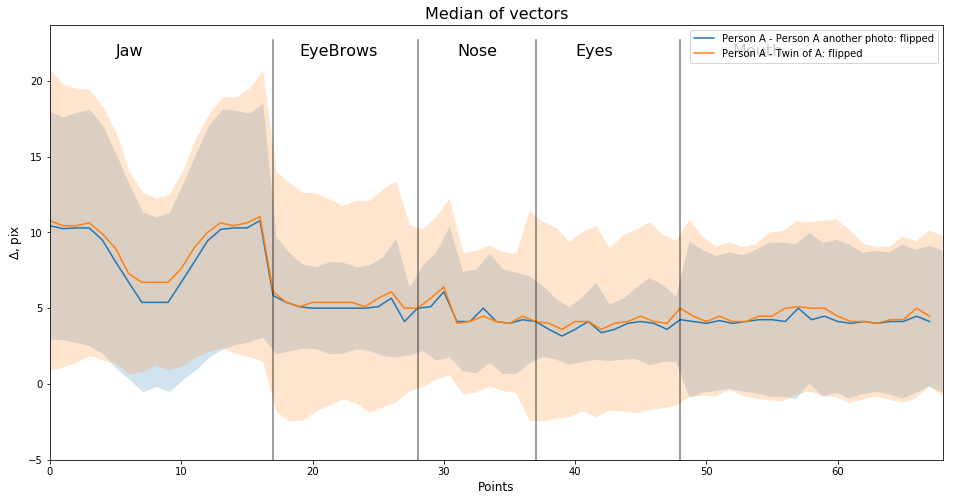

In [64]:
plot_vectors([vectors_same, vectors_different], ['Person A - Person A another photo: flipped', 'Person A - Twin of A: flipped'])

In [0]:
X = np.concatenate([vectors_same, vectors_different], axis = 0)
y = np.concatenate([np.ones(len(vectors_same)).astype(int), np.zeros(len(vectors_different)).astype(int)], axis =0)

In [0]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [67]:
len(X_train), len(X_test)

(4282, 1836)

In [68]:
svm = SVC(kernel='rbf')
svm.fit(X=X_train, y=y_train)
y_pred = svm.predict(X=X_test)

print(accuracy_score(y_test, y_pred).round(5))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.74183


In [69]:
y_pred = svm.predict(X=X_test)

print(accuracy_score(y_test, y_pred).round(5))

0.74183


In [0]:
vectors_same_test = get_vectors_new(same_test, landmarks, landmarks_flip, flip=True)
vectors_different_test = get_vectors_new(others_test, landmarks, landmarks_flip, flip=True)

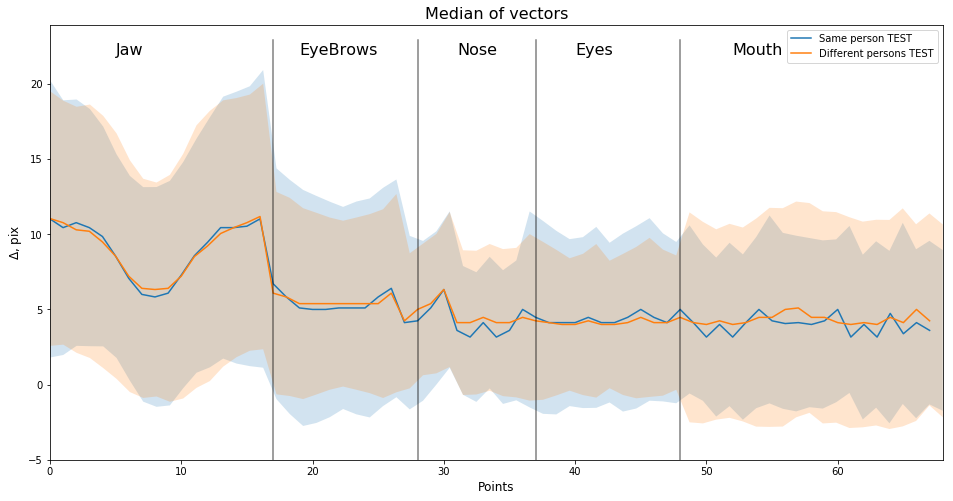

In [57]:
plot_vectors([vectors_same_test, vectors_different_test], ['Same person TEST', 'Different persons TEST'])

In [0]:
validate_X = np.concatenate([vectors_same_test, vectors_different_test], axis = 0)
validate_y = np.concatenate([np.ones(len(vectors_same_test)).astype(int), np.zeros(len(vectors_different_test)).astype(int)], axis =0)

In [59]:
len(validate_X )

3006

In [70]:
y_pred_val = svm.predict(X=validate_X)

print(accuracy_score(validate_y, y_pred_val).round(5))

0.62542


## New preprocess

In [0]:
!pip install git+https://github.com/siriusdemon/pytorch-pcn 
import pcn 

  Cloning https://github.com/siriusdemon/pytorch-pcn to /tmp/pip-req-build-x4oj1nme
  Running command git clone -q https://github.com/siriusdemon/pytorch-pcn /tmp/pip-req-build-x4oj1nme
  Stored in directory: /tmp/pip-ephem-wheel-cache-c8k6_pl_/wheels/99/3b/30/d4e08639df962acfb6911f9b291f877d9a06e946926a317737
Successfully built pcn


In [0]:
os.chdir(cwd)
from dlib_fd import dlib_landmark_detector # face detector

In [0]:
os.chdir(cwd)
from pcn_fd import PCN_face_detector

In [0]:
os.chdir(path)

In [0]:
!ls

DL_TWINS_TEST_of_landmarks_NEW_DATASET.ipynb
DL_VGG2_preprocess.ipynb
mmod_human_face_detector.dat
pairs_test.csv
pairs_train.csv
shape_predictor_68_face_landmarks.dat
train.ipynb
Twins
twins_aligned_cropped_resized
twins_aligned_cropped_resized.zip


In [0]:
# initialize detector:
# cnn_flag = True to use CNN-based model.If False, use HOG-based model
# bb_detector_path = full path except name to bounding box detector (first stage of face detection)
# landmark_predictor_path = full path except name to 68-points trained weights for detector of face landmarks

dfd = dlib_landmark_detector(cnn_flag='True', 
                             bb_detector_path = './mmod_human_face_detector.dat', 
                             landmark_predictor_path = './shape_predictor_68_face_landmarks.dat' )

In [0]:
!ls

DL_TWINS_TEST_of_landmarks_NEW_DATASET.ipynb
DL_VGG2_preprocess.ipynb
mmod_human_face_detector.dat
pairs_test.csv
pairs_train.csv
shape_predictor_68_face_landmarks.dat
train.ipynb
Twins
twins_aligned_cropped_resized
twins_aligned_cropped_resized.zip


In [0]:
os.chdir('../')
os.chdir('../')

In [0]:
test_shape1 = list(landmarks_aligned['90290d28.jpg'])
test_shape2 = list(landmarks_aligned['90290d13.jpg_f'])

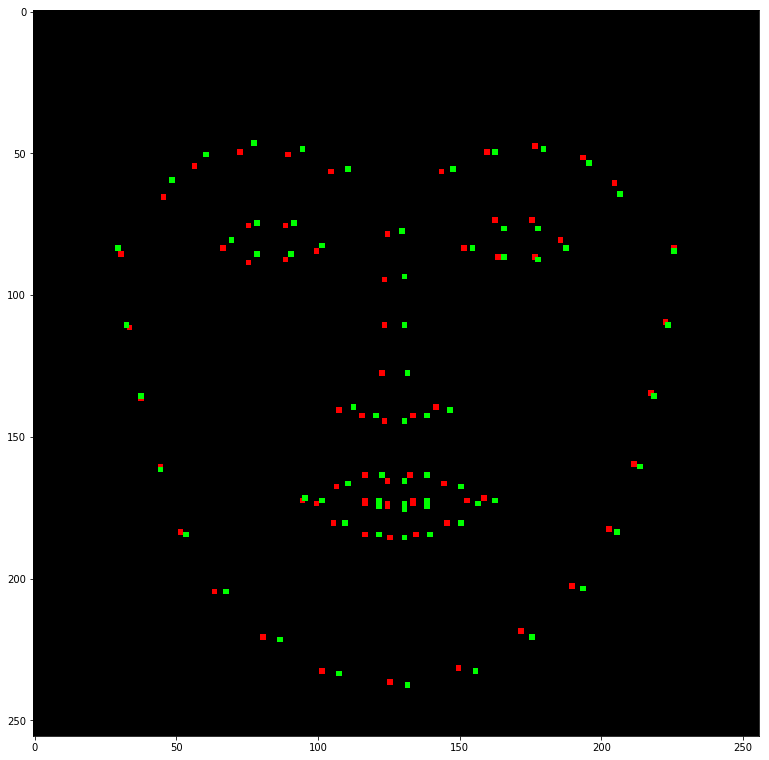

In [0]:
plt.figure(figsize=(13,16))
plot_ = np.zeros((256,256, 3), dtype=np.uint8)
size = 1
for [j,i] in test_shape1:
  plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 0] = 255
  plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 1] = 0
  plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 2] = 0
for [j,i] in test_shape2:
  plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 0] = 0
  plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 1] = 255
  plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 2] = 0

  plt.imshow(plot_)
plt.show()

In [0]:
landmarks_aligned.head()

,90366d13.jpg,90366d13.jpg_f,90366d9.jpg,90366d9.jpg_f,90046d17.jpg,90046d17.jpg_f,90046d56.jpg,90046d56.jpg_f,90326d11.jpg,90326d11.jpg_f,90326d16.jpg,90326d16.jpg_f,90424d13.jpg,90424d13.jpg_f,90424d23.jpg,90424d23.jpg_f,90290d28.jpg,90290d28.jpg_f,90290d13.jpg,90290d13.jpg_f,90329d25.jpg,90329d25.jpg_f
0,"(30, 111)","(32, 113)","(23, 109)","(33, 110)","(25, 87)","(26, 84)","(34, 79)","(33, 80)","(27, 95)","(17, 105)","(21, 109)","(15, 109)","(34, 95)","(23, 95)","(35, 91)","(24, 91)","(31, 86)","(29, 84)","(28, 84)","(30, 84)","(35, 96)","(16, 88)"
1,"(32, 136)","(33, 137)","(25, 135)","(34, 135)","(26, 113)","(27, 111)","(36, 105)","(35, 106)","(29, 121)","(21, 132)","(24, 134)","(19, 135)","(36, 120)","(24, 122)","(37, 115)","(25, 118)","(34, 112)","(32, 110)","(30, 111)","(33, 111)","(37, 121)","(17, 116)"
2,"(36, 160)","(36, 160)","(30, 160)","(36, 159)","(30, 140)","(32, 138)","(40, 131)","(39, 132)","(33, 146)","(27, 156)","(28, 157)","(24, 158)","(39, 146)","(26, 148)","(41, 140)","(27, 146)","(38, 137)","(37, 135)","(35, 136)","(38, 136)","(40, 146)","(20, 144)"
3,"(42, 183)","(41, 183)","(36, 185)","(40, 183)","(34, 166)","(37, 163)","(47, 155)","(45, 156)","(38, 170)","(33, 180)","(32, 181)","(29, 182)","(45, 171)","(30, 174)","(46, 165)","(31, 172)","(45, 161)","(44, 160)","(41, 161)","(45, 162)","(44, 170)","(24, 171)"
4,"(50, 204)","(49, 203)","(45, 207)","(49, 204)","(41, 191)","(45, 188)","(55, 179)","(53, 180)","(46, 193)","(44, 201)","(39, 204)","(38, 204)","(53, 193)","(39, 197)","(54, 188)","(41, 196)","(52, 184)","(52, 183)","(48, 184)","(54, 185)","(51, 192)","(34, 195)"


In [0]:
os.chdir('../')
!ls

DL_TWINS_TEST_of_landmarks_NEW_DATASET.ipynb
DL_VGG2_preprocess.ipynb
mmod_human_face_detector.dat
pairs_test.csv
pairs_train.csv
shape_predictor_68_face_landmarks.dat
train.ipynb
Twins
twins_aligned_cropped_resized
twins_aligned_cropped_resized.zip


In [0]:
os.chdir('twins_aligned_cropped_resized')
folders = os.listdir('.')
if 'df' in folders:
    folders.remove('df')

landmarks_aligned = pd.DataFrame()
landmarks_aligned_flipped = pd.DataFrame()

for folder in folders:
    image_list = os.listdir(folder)
    if 'keypoints.csv' in image_list:
        image_list.remove('keypoints.csv')

    for image_name in image_list:
        img = cv2.cvtColor( cv2.imread(os.path.join(folder, image_name)).astype(np.uint8), cv2.COLOR_BGR2RGB)
        
        # restore angle
        pcn = PCN_face_detector(img)
        img = pcn.restore(visualize=False)
        print(pcn.get_angle())

        # Face A detect
        dfd.reset()
        dfd.face_detect(img, visualize=False)
        # Face A crop and center
        face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.3)
        
        # Face A get landmark points
        dfd.reset()
        dfd.face_detect(face_cropped, visualize=False)
        img_shape = dfd.get_original_size_landmarks()
        
        # Flip
        face_cropped = np.flip(face_cropped, axis=1)
        dfd.reset()
        dfd.face_detect(face_cropped, visualize=False)
        flipped_img_shape = dfd.get_original_size_landmarks()
        
        """
        plt.figure(figsize=(13,16))
        plot_ = np.zeros((256,256, 3), dtype=np.uint8)
        size = 1
        for [j,i] in img_shape:
          plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 0] = 255
          plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 1] = 0
          plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 2] = 0
        for [j,i] in flipped_img_shape:
          plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 0] = 0
          plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 1] = 255
          plot_[int(round(i))-size:int(round(i))+size, int(round(j))-size:int(round(j))+size, 2] = 0
        plt.imshow(plot_)
        plt.show()
        
        
        print(img_shape[8], img_shape[27])
        """
        
        print(image_name)
        landmarks_aligned[image_name] = [(x,y) for [x,y] in img_shape]
        landmarks_aligned_flipped[image_name]=[(x,y) for [x,y] in flipped_img_shape]


os.chdir('../')

3.2515824772417545
90366d13.jpg
2.522774892859161
90366d9.jpg
1.2643378414213657
90046d17.jpg
-1.893835256807506
90046d56.jpg
-1.0699066808447242
90046d57.jpg
0
90046d18.jpg
0.5945018492639065
90326d11.jpg
-2.8189340326935053
90326d16.jpg
-0.3147431043908
90424d13.jpg
0.2473135432228446
90424d23.jpg
0.9404503216501325
90290d28.jpg
-34.23216328024864
90290d13.jpg
-0.7892479549627751
90329d25.jpg
0.8629817236214876
90329d10.jpg
0
90043d18.jpg
-0.3526002843864262
90043d56.jpg
-4.7117095068097115
90043d57.jpg
0.32742852810770273
90043d17.jpg
-0.4972916515544057
90288d26.jpg
-3.0450858687981963
90288d11.jpg
0
90009d110.jpg
0
90009d40.jpg
0
90009d17.jpg
-0.6420309212990105
90009d83.jpg
0
90009d42.jpg
-0.13592008966952562
90009d60.jpg
-1.3887982070446014
90009d116.jpg
0.3018156113103032
90009d61.jpg
-5.654503628611565
90009d95.jpg
0
90009d98.jpg
0
90009d114.jpg
0
90009d18.jpg
-0.9241334907710552
90140d23.jpg
1.1822898723185062
90140d22.jpg
0.39543001167476177
90140d61.jpg
-0.8016731729730964


In [0]:
landmarks_aligned.shape

(68, 1651)

In [0]:
landmarks_aligned_flipped.shape

(68, 1651)

In [0]:
!ls

DL_TWINS_TEST_of_landmarks_NEW_DATASET.ipynb
DL_VGG2_preprocess.ipynb
mmod_human_face_detector.dat
pairs_test.csv
pairs_train.csv
shape_predictor_68_face_landmarks.dat
train.ipynb
Twins
twins_aligned_cropped_resized
twins_aligned_cropped_resized.zip


In [0]:
landmarks_aligned.to_csv('aligned_landmarks.csv', encoding='utf-8', index=False)
landmarks_aligned_flipped.to_csv('aligned_FLIP_landmarks.csv', encoding='utf-8', index=False)

In [0]:
landmarks_aligned['90415d28.jpg'][:20]

0       (26, 99)
1      (27, 123)
2      (30, 148)
3      (36, 172)
4      (46, 194)
5      (60, 213)
6      (80, 227)
7     (102, 237)
8     (126, 240)
9     (149, 237)
10    (171, 226)
11    (190, 213)
12    (206, 195)
13    (217, 174)
14    (224, 151)
15    (227, 126)
16    (230, 102)
17      (51, 69)
18      (65, 60)
19      (81, 57)
Name: 90415d28.jpg, dtype: object

In [0]:
def get_vectors_new(dataframe)

In [0]:
image_list

['90415d28.jpg', '90415d13.jpg']

In [0]:
def get_vectors_new(folders, stop=None):
    vectors = []
    counter = 0
    
    for 
    
    for id_1, id_2 in zip(dataframe['id_1'],dataframe['id_2']):
        path_1 = os.path.join('twins_aligned_cropped_resized', str(id_1))
        path_2 = os.path.join('twins_aligned_cropped_resized', str(id_2))
        
        img_1_keypoints = pd.read_csv(os.path.join(path_1,'keypoints.csv'), index_col=0)
        img_2_keypoints = pd.read_csv(os.path.join(path_2,'keypoints.csv'), index_col=0)
        
        for image_1 in img_1_keypoints.columns:
            for image_2 in img_2_keypoints.columns:
                if image_1 != image_2:
                    print(id_1, image_1,id_2, image_2)
                    
                    img_1 = cv2.cvtColor( cv2.imread(os.path.join(path_1,image_1)).astype(np.uint8), cv2.COLOR_BGR2RGB)
                    img_2 = cv2.cvtColor( cv2.imread(os.path.join(path_2,image_2)).astype(np.uint8), cv2.COLOR_BGR2RGB)
                    
                    # Face A detect
                    dfd.reset()
                    dfd.face_detect(img_1, visualize=False)
        
                    # Face A crop and center
                    face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
                    dfd.reset()
                    dfd.face_detect(face_cropped, visualize=False)
                    # Face A get landmark points
                    img_1_shape = dfd.get_original_size_landmarks()
                    
                    face_cropped = np.flip(face_cropped, axis=1)
                    dfd.reset()
                    dfd.face_detect(face_cropped, visualize=False)
                    B__img_shape = dfd.get_original_size_landmarks()

In [0]:
landmarks = 

NameError: ignored

In [0]:
def distance(shape1, shape2): 
    return np.sqrt( np.power(shape1 - shape2, 2).sum(axis=1)) #MSE

In [0]:
def get_features( pairs, views, cut_off_num, same_preson=False, flipped=False):
    vectors = []
    counter, nd = 1, 0
    
    if same_preson:
        load = load_same_person_pairs
    else:
        load = load_different_person_pairs
    
    for [img_A, img_B] in iter(load(pairs, views)): 
        # Face A prepare
        img_8bit = np.array( img_A )
        img_8bit = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
        # Face A detect
        dfd.reset()
        dfd.face_detect(img_8bit, visualize=False)
        
        # Face A crop and center
        face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
        dfd.reset()
        dfd.face_detect(face_cropped, visualize=False)
        # Face A get landmark points
        A__img_shape = dfd.get_original_size_landmarks()
        
        if flipped:
            if same_preson:
                # A - A_flipped
                face_cropped = np.flip(face_cropped, axis=1)
                dfd.reset()
                dfd.face_detect(face_cropped, visualize=False)
                B__img_shape = dfd.get_original_size_landmarks()
            else:
                # A - B_Flipped
                img_8bit = np.array( img_B )
                img_8bit = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
                dfd.reset()
                dfd.face_detect(img_8bit, visualize=False)
                face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
                
                face_cropped = np.flip(face_cropped, axis=1)
                dfd.reset()
                dfd.face_detect(face_cropped, visualize=False)
                B__img_shape = dfd.get_original_size_landmarks()
        else:
            # A - B
            img_8bit = np.array( img_B )
            img_8bit = np.pad(img_8bit, ((0,50),(40,40),(0,0)), mode='median')
            dfd.reset()
            dfd.face_detect(img_8bit, visualize=False)
            face_cropped = dlib.get_face_chip(dfd._rescaled_image.copy(), dfd.landmark_shape, size=256, padding=0.15)
            dfd.reset()
            dfd.face_detect(face_cropped, visualize=False)
            B__img_shape = dfd.get_original_size_landmarks()
        
        
        if (A__img_shape is None) or (B__img_shape is None):
            nd +=1
        else:
            vectors.append(distance(A__img_shape, B__img_shape))
            counter+=1
        
        if counter == cut_off_num:
            break
    print('Detected:', counter, 'N/Detected:', nd)
    return vectors

validate

In [0]:
same_test = df_test[(df_test['label']=='Same')]
print('Same test', len(same_test))
others_test = df_test[(df_test['label']!='Same')]
print('others test', len(others_test))

Same test 76
others test 132


In [0]:
vectors_same_test = get_vectors_new(same_test, flip=True)
vectors_different_test = get_vectors_new(others_test, flip=True)